# LightGBM

In [48]:
import re
import math
import queue
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
from scipy import stats
from pprint import pprint
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
data_folder = '../data/%s'

In [23]:
df_train = pd.read_csv(data_folder % 'train_final.csv')
df_train['date'] = pd.to_datetime(df_train['transcationDate'])
df_train = df_train.set_index('transcationDate').sort_index()
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train = df_train.reset_index()
df_train.columns

Index(['transcationDate', 'lat/lng', 'districtL', 'districtS', 'princeInHKD',
       'SFA', 'GFA', 'unitPriceSFA', 'unitPriceGFA', 'estateName', 'floor',
       'dis_mtr', 'dis_school', 'dis_market', 'areaSize', 'date', 'year',
       'month', 'day'],
      dtype='object')

In [24]:
LABEL = 'princeInHKD'
need_features_with_label = ['districtL', 'districtS','floor', 'dis_mtr',
       'dis_school', 'dis_market', 'areaSize', 'year', 'month', 'day','princeInHKD']

cate_features = ['districtL', 'districtS']
num_features = ['floor', 'dis_mtr','dis_school', 'dis_market', 'areaSize']
date_features = ['year', 'month', 'day']
df_train = df_train[need_features_with_label]
df_train.head()

,districtL,districtS,floor,dis_mtr,dis_school,dis_market,areaSize,year,month,day,princeInHKD
0,Hong Kong Island,Causeway Bay,15,5.9657,0.0374,0.1482,882.0,2003,11,18,2200000.0
1,Hong Kong,North Point,1,13284.9770,0.8929,1.4221,545.0,2004,6,1,1790000.0
2,Hong Kong,Sai Yin Pun,7,3.7299,0.1577,0.0238,520.0,2004,6,1,945000.0
3,Hong Kong,Taikoo Shing,4,8.3495,0.1246,0.0263,585.0,2004,6,1,1950000.0
4,Hong Kong,Taikoo Shing,2,8.3495,0.1246,0.0263,983.0,2004,6,1,4950000.0


In [25]:
df_train['districtL'] = df_train['districtL'].replace('HK','Hong Kong').replace('KL','Kowloon')
df_train['floor'] = df_train['floor'].replace('G','0').astype('int64')

In [26]:
mean = df_train[num_features].mean()
std = df_train[num_features].std()
label_nor = 20

In [53]:
print(mean)
print(std)

floor           7.580124
dis_mtr        39.725909
dis_school      0.163729
dis_market      0.225913
areaSize      594.412054
dtype: float64
floor           9.725491
dis_mtr       616.339621
dis_school      0.176334
dis_market      0.290479
areaSize      299.757712
dtype: float64


In [27]:
df_train[num_features] = (df_train[num_features] - mean) / std
df_train[LABEL] = np.log(df_train[LABEL]) / label_nor

In [28]:
df_train[LABEL].describe()

count    516229.000000
mean          0.764239
std           0.037887
min           0.460517
25%           0.742789
50%           0.763590
75%           0.784977
max           1.036163
Name: princeInHKD, dtype: float64

In [29]:
split_num = -1000
df_train_copy = pd.get_dummies(df_train)
train_data = df_train_copy[:split_num]
test_data = df_train_copy[split_num:]
test_data.head()

,floor,dis_mtr,dis_school,dis_market,areaSize,year,month,day,princeInHKD,districtL_Hong Kong,...,districtS_Wan Chai,districtS_Wanchai,districtS_Western mid-levels,districtS_Whampao,districtS_Wong Tai Sin,districtS_Yau Ma Tei,districtS_Yau Tong,districtS_Yau Yat Chuen,districtS_Yau Yat Tsuen,districtS_Yuen Long
515229,0.762931,-0.053815,-0.253663,-0.154616,3.221228,2018,8,2,0.879757,0,...,0,0,0,0,0,0,0,0,0,0
515230,1.482689,-0.038509,1.046712,0.175184,-0.134816,2018,8,2,0.780364,0,...,0,0,0,0,0,0,0,0,0,0
515231,-0.470940,-0.051358,-0.057444,1.766348,1.506510,2018,8,2,0.868285,0,...,0,0,0,0,0,0,0,0,0,0
515232,0.762931,-0.050866,-0.225875,0.553869,1.820096,2018,8,2,0.840562,0,...,0,0,0,0,0,0,0,0,0,0
515233,0.762931,-0.042505,0.140476,-0.349810,-0.014719,2018,8,2,0.784596,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
train_X = train_data.drop(LABEL,axis = 1)
train_y = train_data[LABEL]
val_X = test_data.drop(LABEL,axis = 1)
val_y = test_data[LABEL]

# Training

In [31]:
model_param = {'lr': 0.01, 'depth': 10, 'tree': 5000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': {'l2', 'l1'},
    'max_depth': model_param['depth'],
    'num_leaves': model_param['leaf'],
    'min_data_in_leaf': 20,
    'learning_rate': model_param['lr'],
    'feature_fraction': 1,
    'bagging_fraction': model_param['sample'],
    'bagging_freq': 1,
    'bagging_seed': model_param['seed'],
    'verbose': 0
}

In [32]:
lgb_train = lgb.Dataset(train_X, train_y)
lgb_eval = lgb.Dataset(val_X, val_y)
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=5000,
    valid_sets=lgb_eval,
    verbose_eval = 100,
    early_stopping_rounds = 100
)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 0.0183738	valid_0's l2: 0.000625372
[200]	valid_0's l1: 0.0135694	valid_0's l2: 0.000410817
[300]	valid_0's l1: 0.011582	valid_0's l2: 0.00035083
[400]	valid_0's l1: 0.0106658	valid_0's l2: 0.000328004
[500]	valid_0's l1: 0.0101061	valid_0's l2: 0.000315108
[600]	valid_0's l1: 0.00978559	valid_0's l2: 0.000308878
[700]	valid_0's l1: 0.00957562	valid_0's l2: 0.000304231
[800]	valid_0's l1: 0.00940973	valid_0's l2: 0.000300837
[900]	valid_0's l1: 0.00924417	valid_0's l2: 0.000297769
[1000]	valid_0's l1: 0.00912281	valid_0's l2: 0.000295407
[1100]	valid_0's l1: 0.00900557	valid_0's l2: 0.00029259
[1200]	valid_0's l1: 0.0088937	valid_0's l2: 0.000289937
[1300]	valid_0's l1: 0.00880437	valid_0's l2: 0.000287762
[1400]	valid_0's l1: 0.00870661	valid_0's l2: 0.000285526
[1500]	valid_0's l1: 0.00864005	valid_0's l2: 0.000283876
[1600]	valid_0's l1: 0.00856985	valid_0's l2: 0.000282441
[1700]	valid_0's l1: 0.0085

In [33]:
ypred = gbm.predict(val_X) * 20.0

In [34]:
ypred = np.power(np.e,ypred)

In [50]:
mean_squared_error(ypred,val_y)

518421040282853.06

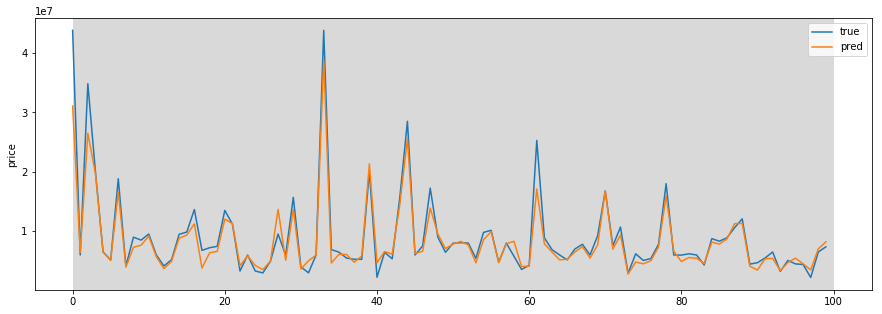

In [47]:
myplot(val_y,ypred,100)

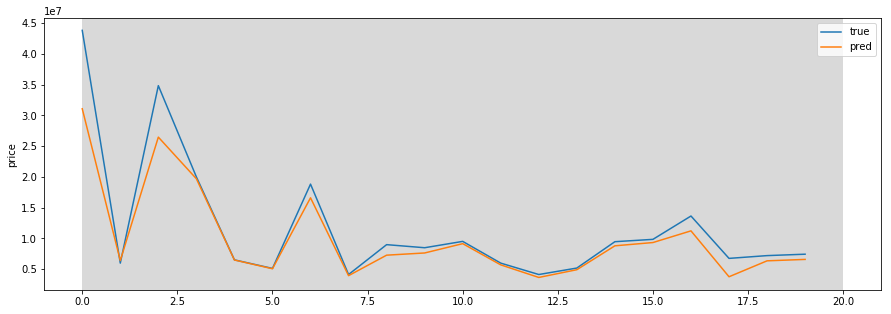

In [52]:
myplot(val_y,ypred,20)

In [46]:
def myplot(val_y,ypred,warmup_steps):
    df_plot = pd.DataFrame()
    df_plot['true'] = pd.Series(val_y.values)
    df_plot['pred'] = pd.Series(ypred)
#     warmup_steps = 50
    signal_pred = df_plot[['pred']][:warmup_steps]

    # Get the true output-signal from the data-set.
    signal_true = df_plot[['true']][:warmup_steps]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')

    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

    # Plot labels etc.
    plt.ylabel('price')
    plt.legend()
    plt.show()

In [90]:
test_tmp = test_data[test_data['districtS_Tseung Kwan O'] == 1]

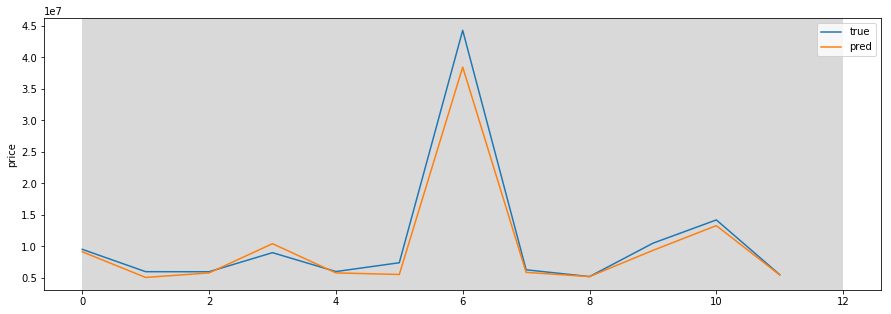

In [84]:
# val_X = test_tmp.drop(LABEL,axis = 1)
# val_y = test_tmp[LABEL]
# ypred = gbm.predict(val_X) * 20.0
# ypred = np.power(np.e,ypred)
# val_y = np.power(np.e,val_y * 20.0)
# myplot(val_y,ypred,12)

In [13]:
df_train_for_test = pd.read_csv(data_folder % 'train_final.csv')

In [14]:
df_train_for_test['date'] = pd.to_datetime(df_train_for_test['transcationDate'])
df_train_for_test = df_train_for_test.set_index('transcationDate').sort_index()

In [20]:
pds_name = df_train_for_test.reset_index()['estateName']
df_train_for_test_copy = df_train_for_test.copy()
# df_train_for_test_copy['estateName'] = pds_name
df_train_for_test_copy.set_index('estateName',inplace = True)

In [21]:
select_test_name = 'Hoi To Court&海都大廈'
df_train_for_test_copy.loc[select_test_name].reset_index().drop('estateName',axis = 1)
df_train_for_test_copy
df_train_for_test_copy

,lat/lng,districtL,districtS,princeInHKD,SFA,GFA,unitPriceSFA,unitPriceGFA,floor,dis_mtr,dis_school,dis_market,areaSize,date
estateName,,,,,,,,,,,,,,
Hoi To Court&海都大廈,"22.2840652,114.1921005",Hong Kong Island,Causeway Bay,2200000.0,NaN,882.0,NaN,2494.0,15,5.9657,0.0374,0.1482,882.000000,2003-11-18
Bedford Gardens,"22.2892284,114.2044144",Hong Kong,North Point,1790000.0,545.0,650.0,3284.0,2754.0,1,13284.9770,0.8929,1.4221,545.000000,2004-06-01
Kwan Yick Building Phase 2,"22.2875633,114.1379318",Hong Kong,Sai Yin Pun,945000.0,NaN,520.0,NaN,1817.0,7,3.7299,0.1577,0.0238,520.000000,2004-06-01
TaiKoo Shing,"22.2865467,114.2189865",Hong Kong,Taikoo Shing,1950000.0,NaN,585.0,NaN,3333.0,4,8.3495,0.1246,0.0263,585.000000,2004-06-01
TaiKoo Shing,"22.2865467,114.2189865",Hong Kong,Taikoo Shing,4950000.0,NaN,983.0,NaN,5036.0,2,8.3495,0.1246,0.0263,983.000000,2004-06-01
TaiKoo Shing,"22.2865467,114.2189865",Hong Kong,Taikoo Shing,4530000.0,NaN,907.0,NaN,4994.0,1,8.3495,0.1246,0.0263,907.000000,2004-06-01
TaiKoo Shing,"22.2865467,114.2189865",Hong Kong,Taikoo Shing,4400000.0,NaN,883.0,NaN,4983.0,2,8.3495,0.1246,0.0263,883.000000,2004-06-01
TaiKoo Shing,"22.2865467,114.2189865",Hong Kong,Taikoo Shing,2820000.0,NaN,675.0,NaN,4178.0,1,8.3495,0.1246,0.0263,675.000000,2004-06-01
The Eastborne,"22.2803555,114.23059840000002",Hong Kong,Shaukeiwan,126000.0,335.0,475.0,376.0,265.0,3,9.3936,0.0900,0.1250,335.000000,2004-06-01
